# Sort Points According to Hilbert Curve

https://en.wikipedia.org/wiki/Hilbert_curve

https://en.wikipedia.org/wiki/Hilbert_R-tree

## Building Hilbert Curve

In [3]:
from typing import Tuple


# rotate/flip a quadrant appropriately
def rot(n: int, x: int, y: int, rx: int, ry: int) -> Tuple[int, int]:
    if ry == 0:
        if rx == 1:
            x = n - 1 - x
            y = n - 1 - y

        x, y = y, x
    return x, y


# convert (x, y) to d
def xy2d (n: int, x: int, y: int) -> int:
    d = 0
    s = n // 2
    while s > 0:
        rx = 1 if (x & s) > 0 else 0
        ry = 1 if (y & s) > 0 else 0
        d += s * s * ((3 * rx) ^ ry)
        x, y = rot(n, x, y, rx, ry)
        s //= 2
    return d


# convert d to (x, y)
def d2xy(n: int, d: int) -> Tuple[int, int]:
    t = d
    x = y = 0
    s = 1
    while s < n:
        rx = 1 & (t // 2)
        ry = 1 & (t ^ rx)
        x, y = rot(s, x, y, rx, ry)
        x += s * rx
        y += s * ry
        t //= 4
        s *= 2
    return x, y

def print_curve(n: int):
    grids = [[0] * n for _ in range(n)]
    for d in range(n * n):
        x, y = d2xy(n, d)
        grids[x][y] = d
    for line in grids:
        print(*line, sep='\t')
    print()
    grids = [[xy2d(n, x, y) for y in range(n)] for x in range(n)]
    for line in grids:
        print(*line, sep='\t')


print_curve(4)

0	3	4	5
1	2	7	6
14	13	8	9
15	12	11	10

0	3	4	5
1	2	7	6
14	13	8	9
15	12	11	10


## Sort Points

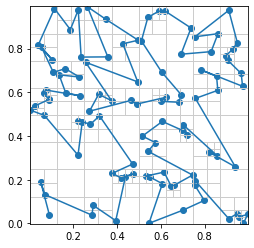

In [4]:
import operator
import random
from typing import Iterable, List


class Point:
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y
    def __add__(self, other: 'Point') -> 'Point':
        return Point(self.x + other.x, self.y + other.y)
    def __sub__(self, other: 'Point') -> 'Point':
        return Point(self.x - other.x, self.y - other.y)
    def __truediv__(self, other: float) -> 'Point':
        return Point(self.x / other, self.y / other)


class Box:
    def __init__(self, *, center: Point | None = None, extent: Point | None = None) -> None:
        if center is not None and extent is not None:
            self.min = center - extent
            self.max = center + extent
        else:
            self.min = Point(float('inf'), float('inf'))
            self.max = Point(float('-inf'), float('-inf'))

    def __iadd__(self, point: Point):
        self.min = Point(min(self.min.x, point.x), min(self.min.y, point.y))
        self.max = Point(max(self.max.x, point.x), max(self.max.y, point.y))
        return self


def hilbert_sort(elements: Iterable[Point]) -> List[Point]:
    class Node:
        def __init__(self, n: int, x: int, y: int, elements: Iterable[Point]) -> None:
            self.children: List['Node'] = []
            self.elements = list(elements)
            self.n = n
            self.x = x
            self.y = y
    
    bounds = Box()
    for e in elements:
        bounds += e
    bounds_center = (bounds.min + bounds.max) / 2
    bounds_size = max(bounds.max.x - bounds.min.x, bounds.max.y - bounds.min.y)
    bounds = Box(center=bounds_center, extent=Point(bounds_size / 2, bounds_size / 2))
    
    root = Node(1, 0, 0, elements)
    nodes = [root]
    while len(nodes) > 0:
        node = nodes.pop()
        if len(node.elements) <= 1:
            continue
        grid_size = bounds_size / node.n
        grid_center = bounds.min + Point(grid_size * (node.x + 0.5), grid_size * (node.y + 0.5))
        children = [], [], [], []
        for e in node.elements:
            gx = 0 if e.x < grid_center.x else 1
            gy = 0 if e.y < grid_center.y else 1
            children[gx * 2 + gy].append(e)
        node.elements = []
        node.children = [
            Node(2 * node.n, 2 * node.x, 2 * node.y, children[0]),
            Node(2 * node.n, 2 * node.x, 2 * node.y + 1, children[1]),
            Node(2 * node.n, 2 * node.x + 1, 2 * node.y, children[2]),
            Node(2 * node.n, 2 * node.x + 1, 2 * node.y + 1, children[3]),
        ]
        nodes += node.children
    
    sorted_elements = []
    nodes = [root]
    while len(nodes) > 0:
        node = nodes.pop()
        if len(node.elements) > 0:
            distance = xy2d(node.n, node.x, node.y) / (node.n ** 2 - 1)
            sorted_elements.append((node.elements[0], distance))
            continue
        if len(node.children) > 0:
            nodes += node.children
    sorted_elements.sort(key=lambda x: x[1])
    
    def plot():
        scatter_x = [p.x for p, _ in sorted_elements]
        scatter_y = [p.y for p, _ in sorted_elements]
        rectangles: List[Box] = []
        nodes = [root]
        while len(nodes) > 0:
            node = nodes.pop()
            if len(node.children) == 0:
                grid_size = bounds_size / node.n
                grid_center = bounds.min + Point(grid_size * (node.x + 0.5), grid_size * (node.y + 0.5))
                grid_extent = Point(grid_size / 2, grid_size / 2)
                rectangles.append(Box(center=grid_center, extent=grid_extent))
            else:
                nodes += node.children

        from matplotlib import pyplot as plt
        from matplotlib.patches import Rectangle
        from matplotlib.lines import Line2D

        fig, ax = plt.subplots()
        ax.scatter(scatter_x, scatter_y)
        ax.set(xlim=[bounds.min.x, bounds.max.x], ylim=[bounds.min.y, bounds.max.y])
        ax.set_aspect('equal', 'box')
        for r in rectangles:
            ax.add_patch(Rectangle((r.min.x, r.min.y), r.max.x - r.min.x, r.max.y - r.min.y, linewidth=1, edgecolor=(0.8,0.8,0.8), facecolor='none'))
        ax.add_line(Line2D(scatter_x, scatter_y))
    plot()

    return [e for e, _ in sorted_elements]

rand_points = [Point(random.random(), random.random()) for _ in range(100)]
_ = hilbert_sort(rand_points)